In [43]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pypalettes import load_cmap
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from highlight_text import fig_text, ax_text

df = pd.read_csv('GCB2022v27_percapita_flat.csv')
df = df[df['Year']==df['Year'].max()]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['continent'] == 'Europe']
data = world.merge(df, how='left', left_on='name', right_on='Country')
data = data[~data['Country'].isin(['Russia', 'Iceland'])]
data = data[['Country', 'Total', 'geometry']]
data = data.dropna()
data = data.sort_values('Total', ascending=False)
data.columns = ['country', 'co2Capita', 'geometry']
data.to_file('data.geojson', driver='GeoJSON')
data.head()

/var/folders/m2/jfzxyg4s0xz3jyw5f94r7tcm0000gn/T/ipykernel_38143/2171934390.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,country,co2Capita,geometry
20,Luxembourg,13.067857,"POLYGON ((6.04307 50.12805, 6.24275 49.90223, ..."
6,Poland,8.577376,"POLYGON ((23.48413 53.91250, 23.52754 53.47012..."
21,Belgium,8.243806,"POLYGON ((6.15666 50.80372, 6.04307 50.12805, ..."
14,Germany,8.089741,"POLYGON ((14.11969 53.75703, 14.35332 53.24817..."
22,Netherlands,8.058958,"POLYGON ((6.90514 53.48216, 7.09205 53.14404, ..."


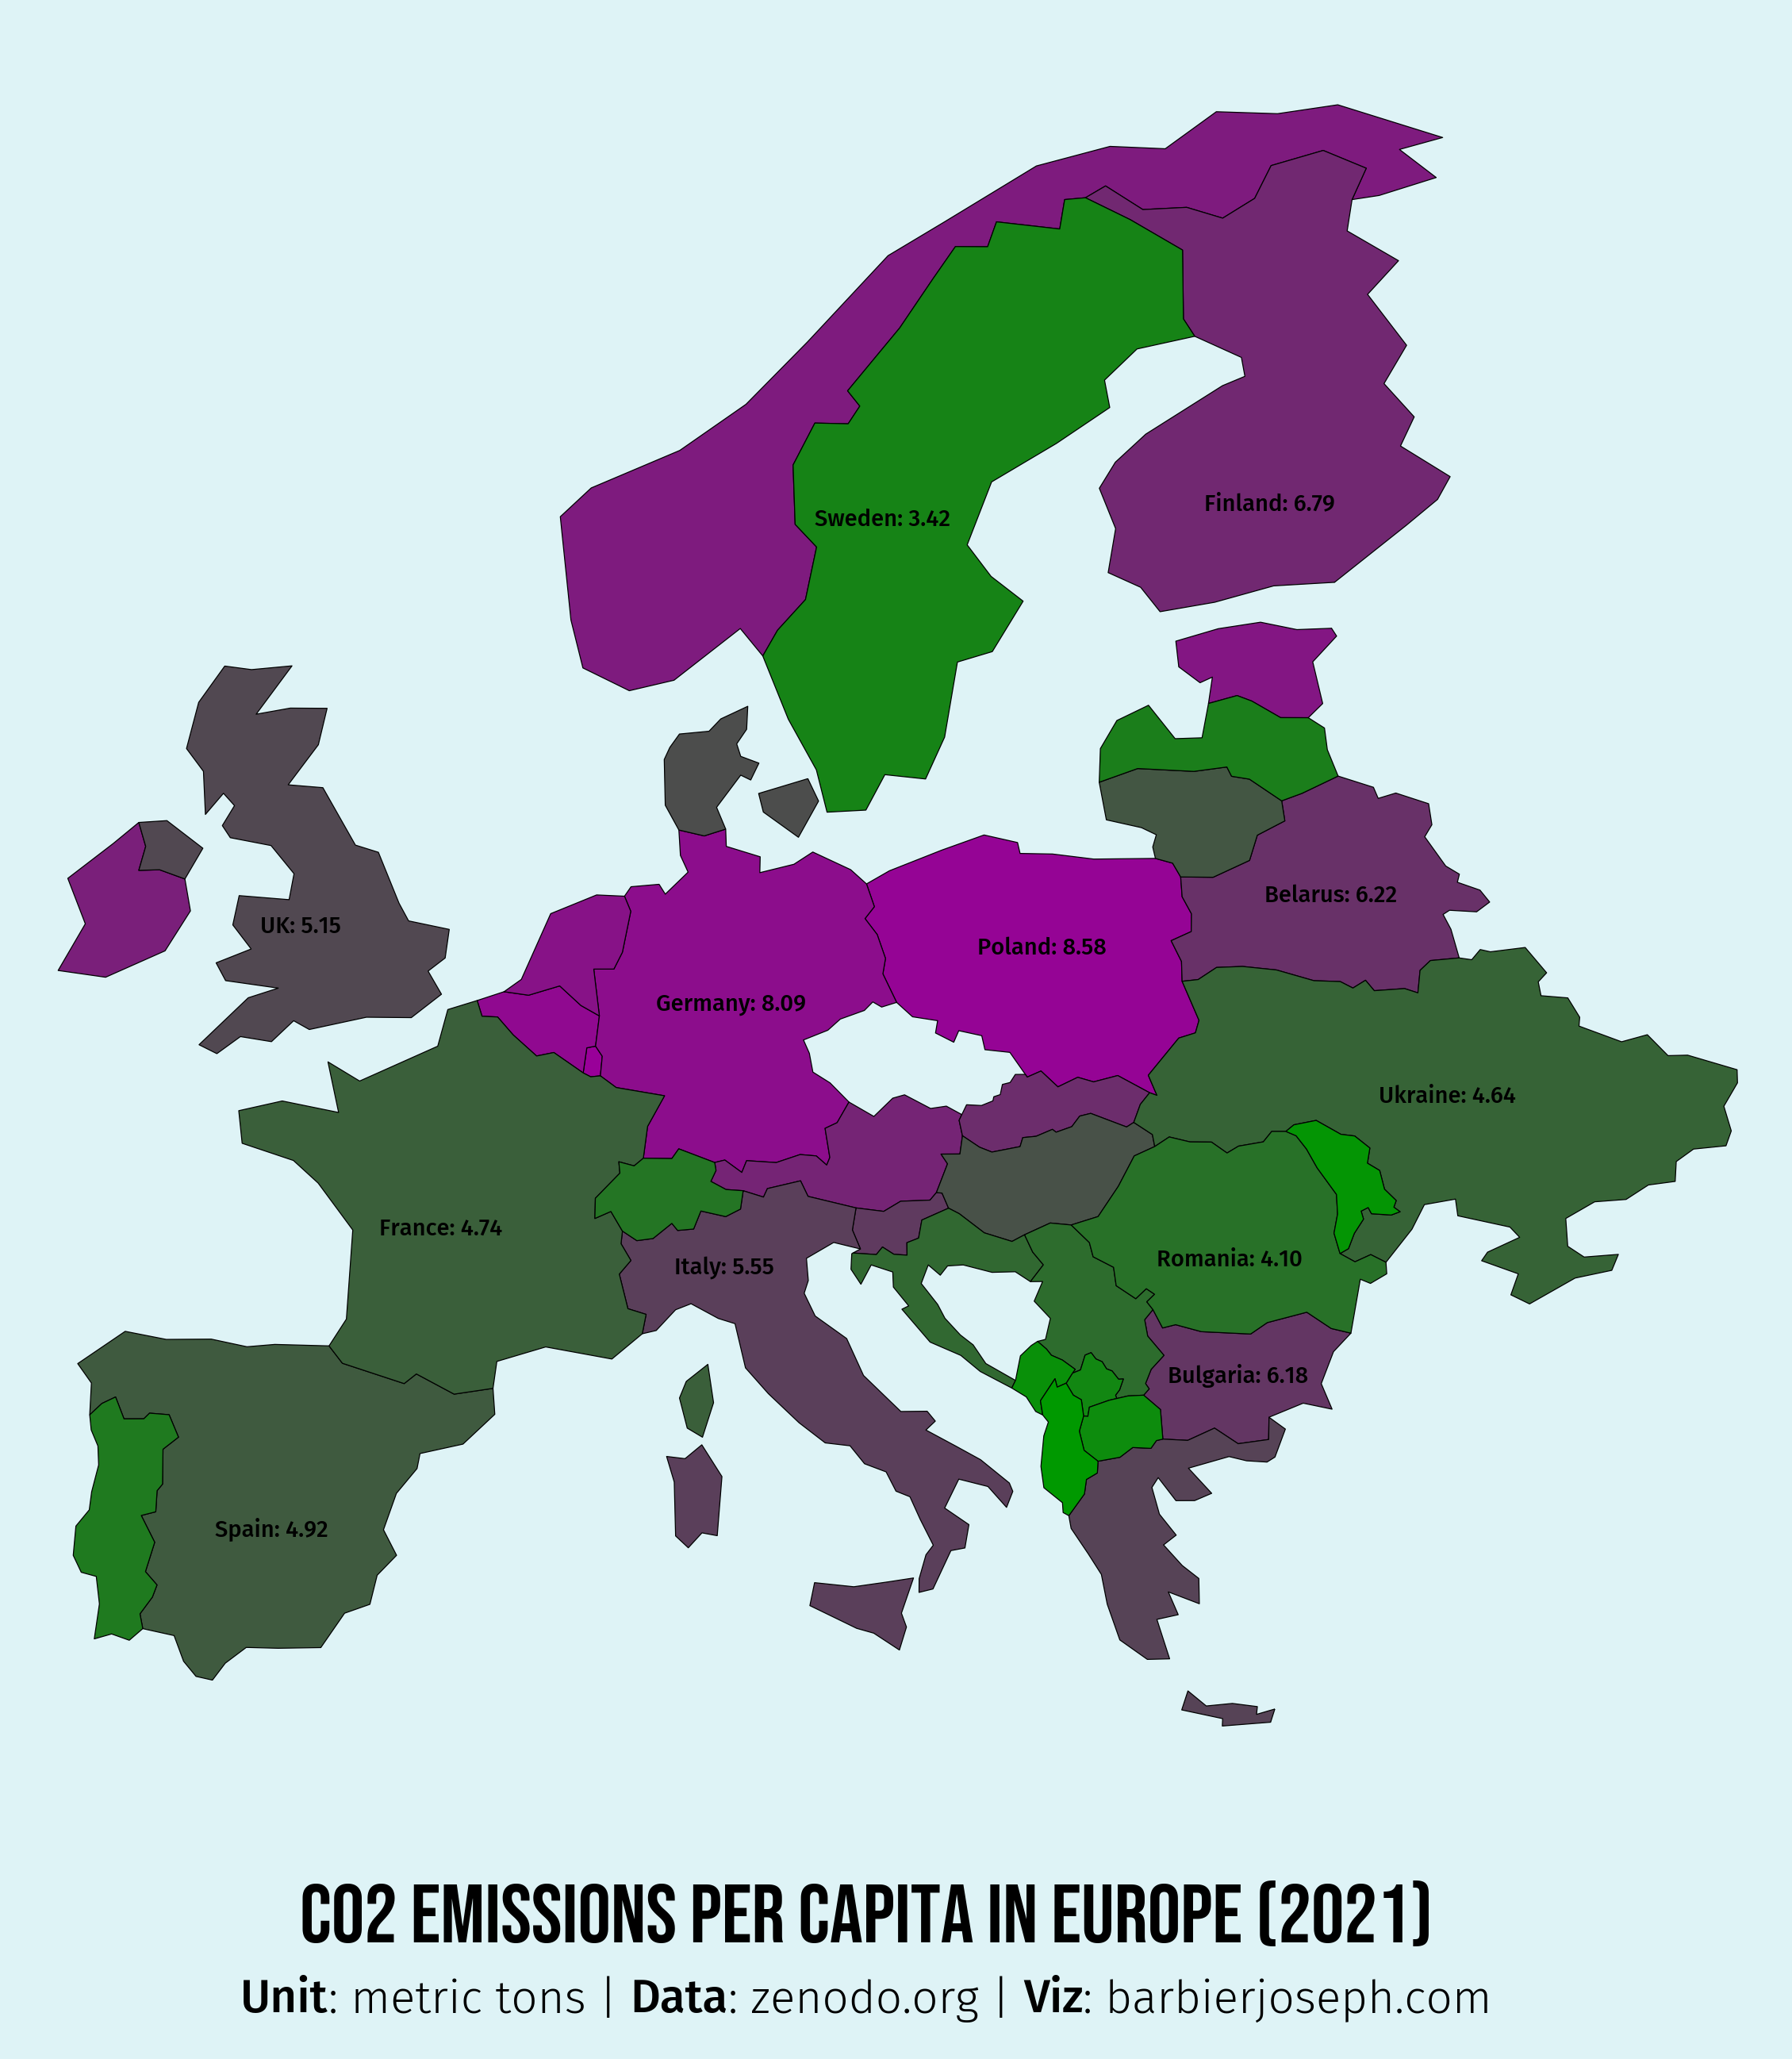

In [66]:
# load the colormap
cmap = load_cmap('classic', type='continuous')
background_color = '#def3f6'
text_color = 'black'

# load the font
personal_path = '/Users/josephbarbier/Library/Fonts/'
font = FontProperties(fname=personal_path + 'BebasNeue-Regular.ttf')
other_font = FontProperties(fname=personal_path + 'FiraSans-Light.ttf')
other_bold_font = FontProperties(fname=personal_path + 'FiraSans-Medium.ttf')

# initialize the figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
fig.set_facecolor(background_color)

# create the plot
data.plot(ax=ax, cmap=cmap, edgecolor='black', linewidth=0.3)

# custom axis
ax.set_xlim(-11, 41)
ax.set_ylim(32, 73)
ax.set_axis_off()

# # create a sub axes
# sub_ax = inset_axes(
#    parent_axes=ax,
#    width="45%",
#    height="40%",
#    loc='upper left'
# )
# sub_ax.spines[['top', 'right']].set_visible(False)
# sub_ax.spines[['bottom', 'left']].set_linewidth(2)
# sub_ax.tick_params(axis='y', labelsize=6)

# # create the lollipop plot
# max_value = data['co2Capita'].max()
# min_value = data['co2Capita'].min()
# for country, total in data[['country', 'co2Capita']].values:
#    total_norm = 1 - (total - min_value) / (max_value - min_value)
#    sub_ax.scatter(total, country, s=100, color=cmap(total_norm))
#    sub_ax.hlines(country, 0, total, color=cmap(total_norm), lw=2)

# compute centroids and display the total
adjustments = {
    'France': (9, 3),
    'Italy': (-2.4, 2.5),
    'Lithuania': (0, -0.6),
    'Finland': (0, -2),
    'Romania': (0, -0.5),
    'Bulgaria': (0, 0),
    'Greece': (-1.2, -0.8),
    'Croatia': (0, -1),
    'Cyprus': (0, -1),
    'Ireland': (0, -1),
    'Malta': (0, -1),
    'Slovenia': (0, -1),
    'Slovakia': (-0.7, -0.8),
    'Estonia': (0, -0.7),
    'Latvia': (0, -0.5),
    'Belgium': (0, -0.7),
    'Austria': (0, -0.4),
    'Spain': (0, -1),
    'Portugal': (-0.5, -1),
    'Luxembourg': (0, -1),
    'Germany': (-0.2, 0),
    'Hungary': (-0.3, -1),
    'Czechia': (0, -1),
    'Poland': (0, 0.2),
    'Sweden': (-1.5, -0.5),
    'Denmark': (0, -1),
    'Netherlands': (0, 0),
    'United Kingdom': (0, -1),
    'Switzerland': (0, -0.5),
}
data_projected = data.to_crs(epsg=3035)
data_projected['centroid'] = data_projected.geometry.centroid
data['centroid'] = data_projected['centroid'].to_crs(data.crs)
countries_to_annotate = data['country'].tolist()
countries_to_annotate = [
   'France', 'Italy', 'Romania', 'Poland',
   'Finland', 'Ukraine',
   'Spain', 'Germany', 
   'Sweden', 'United Kingdom', 'Bulgaria',
   'Belarus'
]
for country in countries_to_annotate:
   centroid = data.loc[data['country'] == country, 'centroid'].values[0]
   x, y = centroid.coords[0]
   try:
      x += adjustments[country][0]
      y += adjustments[country][1]
   except KeyError:
      pass
   rate = data.loc[data['country'] == country, 'co2Capita'].values[0]
   if country=='United Kingdom':
      country = 'UK'
   ax_text(
      x=x, y=y, s=f"{country}: {rate:.2f}", fontsize=7, font=other_bold_font, color=text_color,
      ha='center', va='center', ax=ax
   )

# title
fig_text(
   s="CO2 emissions per capita in Europe (2021)", x=0.5, y=0.1,
   color=text_color, fontsize=25, font=font, ha='center', va='top', ax=ax
)

# subtitle
fig_text(
   s="<Unit>: metric tons | <Data>: zenodo.org | <Viz>: barbierjoseph.com", x=0.5, y=0.06,
   color=text_color, fontsize=14, font=other_font, ha='center', va='top', ax=ax,
   highlight_textprops=[{'font': other_bold_font}, {'font': other_bold_font}, {'font': other_bold_font}]
)

# display the plot
plt.savefig('map.png', dpi=300)
plt.show()

In [ ]:
# compute centroids and display the total
# data_projected = data.to_crs(epsg=3035)
# data_projected['centroid'] = data_projected.geometry.centroid
# data['centroid'] = data_projected['centroid'].to_crs(data.crs)
# countries_to_annotate = data['Country'].tolist()
# for country in countries_to_annotate:
#    centroid = data.loc[data['Country'] == country, 'centroid'].values[0]
#    x, y = centroid.coords[0]
#    rate = data.loc[data['Country'] == country, 'Total'].values[0]